In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import random
import pdb
import plotly.express as px
import plotly.graph_objects as go
import pickle
import scipy.io
from matplotlib.font_manager import FontProperties
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
import matplotlib.animation as animation
import glob
#from natsort import natsorted
from PIL import Image

def create_gif(pth, time_ind):
    #files = glob.glob(r"./imgs/*.png")
    files = glob.glob(os.path.join(pth,'*.png'))
    files = natsorted(files)
    image_array = []
    
    def update(i):
        im.set_array(image_array[i])
        return im, 
    
    for my_file in files:

        image = Image.open(my_file)
        image_array.append(image)
    
    # Create the figure and axes objects
    fig, ax = plt.subplots()

    # Set the initial image
    im = ax.imshow(image_array[0], animated=True)
    
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=100, blit=True,repeat_delay=10,)

    # Show the animation
    #plt.show()

    #animation_fig.save("./imgs/animated_{}.gif".format(time_ind))
    animation_fig.save(os.path.join(pth,'animated_{}.gif').format(time_ind))
    pass

### Adding gamma_0 value for SINR computation ####

$\gamma = \frac{|h|_s^2P_t}{|h|_i^2P_t + N_0B}$

Assuming power transmitted power is same from all BSs then we have 

$\gamma = \frac{|h|_s^2}{|h|_i^2 + \frac{1}{\gamma_0}}$


where $\gamma_0 = P_t/N_0B$, you can assume P_t = 10 dBm, and the below calculations for $N_0$

In [2]:
## transmit power ###
Pt_dBm = 10  # Transmit power in dBm

#### Noise power ####
k = 1.38e-23  # Boltzmann's constant
T = 290       # Temperature in Kelvin
B = 10e6       # Bandwidth in Hz

# Calculate noise spectral density in Watts/Hz
Noise_spectral_density = k * T

# Convert noise spectral density to dBm/Hz
# Convert to Watts first then to dBm (1 mW = 0.001 W)
Noise_spectral_density_W = Noise_spectral_density * 1000  # Convert to mW
Noise_spectral_density_dBm = 10 * np.log10(Noise_spectral_density_W)
print('Noise_spectral_density_dBm', Noise_spectral_density_dBm)

# Calculate total noise power in Watts then convert to dBm
N_thermal = Noise_spectral_density * B  # Total noise power in Watts
N_thermal_dBm = 10 * np.log10(N_thermal * 1000)  # Convert noise power to dBm
print('thermal_noise_power(dBm)', N_thermal_dBm)

##### gamma_0 in dB ############
gamma_0_dB = Pt_dBm - N_thermal_dBm  # Calculate SNR in dB
#print('gamma_0 (dB)', gamma_0_dB)

##### gamma_0 ######
gamma_0 = np.power(10, gamma_0_dB/10)
print('1/gamma_0', 1/gamma_0)

Noise_spectral_density_dBm -173.97722915699805
thermal_noise_power(dBm) -103.97722915699808
1/gamma_0 4.001999999999999e-12


### 
CDF of SINR computed for F($\gamma$), for different channel realizations,
below is when the the device is at a mean distance of 1m from the serving BS with a standard deviation of 0.1 m, and mean distance from the interfering BS at 4 meters with std of 0.1m 

In [3]:
def return_cdf(a):
    sorted_a = np.sort(a)
    cdf = np.arange(1, len(sorted_a) + 1) / len(sorted_a)
    return sorted_a, cdf

In [4]:
############## Creating distances intra and inter ########
M = 10 # number of sub-networks 

Ts = 10000 # number of time slots
J = 5 # number of devices
N = 6
f_c = 1.3 #GHz
TxRxds = np.zeros((Ts, M, M*J))
d_intra = np.abs(np.random.normal(0.5,0.1,M*J))
d_intra = np.reshape(d_intra, (M,J))

In [5]:
'''
for ts in range(Ts):
    d_inter_intra_arr = np.zeros((M, M*J))
    for cnt, m in enumerate(range(M)):
        d_inter = []
        #total_range = list(range(1, 21))
        for _ in range(M-1):
            d_mean = random.randint(2,20)
            #d_mean = random.choice(total_range)
            #total_range = [t for t in total_range if t!=d_mean]
            
            #d_mean = np.random.uniform(1,20)
            ds = np.abs(np.random.normal(d_mean, 0.1, J))
            d_inter.extend(ds)
        d_inter = np.array(d_inter)
        d_inter_intra = np.insert(d_inter, cnt*M, d_intra[m,:])
        #print(d_inter_intra)
        d_inter_intra_arr[m] = d_inter_intra
    TxRxds[ts] = d_inter_intra_arr
''';

In [6]:
def generate_random_point(grid_size):
    return np.random.uniform(0, grid_size, 2)

def generate_random_velocity():
    angle = np.random.uniform(0, 2 * np.pi)
    velocity = 11.11  # 40 km/h in m/s
    return np.array([velocity * np.cos(angle), velocity * np.sin(angle)])

def is_within_grid(point, grid_size):
    return all(0 <= coord <= grid_size for coord in point)

def handle_boundary_collisions(point, grid_size):
    angle = np.random.uniform(0, 2 * np.pi)
    velocity = 11.11
    if point[0] <= 0 or point[0] >= grid_size:
        angle = np.pi - angle if point[0] <= 0 else -angle
    if point[1] <= 0 or point[1] >= grid_size:
        angle = -np.pi / 2 - angle if point[1] <= 0 else np.pi / 2 - angle
    return np.array([velocity * np.cos(angle), velocity * np.sin(angle)])

def handle_ap_collisions(points, velocities, min_distance):
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            if np.linalg.norm(points[i] - points[j]) < min_distance:
                # Adjust direction randomly for both APs
                velocities[i] = generate_random_velocity()
                velocities[j] = generate_random_velocity()
    return velocities

def update_positions(points, velocities, tau, grid_size, min_distance):
    new_points = points + velocities * tau
    for i, point in enumerate(new_points):
        if not is_within_grid(point, grid_size):
            velocities[i] = handle_boundary_collisions(point, grid_size)
        new_points[i] = points[i] + velocities[i] * tau  # Recalculate with new velocity
    velocities = handle_ap_collisions(new_points, velocities, min_distance)
    return new_points, velocities

# Initialize parameters
grid_size = 20
num_points = M
min_distance = 2
tau = 0.01  # time interval in seconds

# Initialize points and velocities
points = np.array([generate_random_point(grid_size) for _ in range(num_points)])
velocities = np.array([generate_random_velocity() for _ in range(num_points)])
init_cents = points
# Simulation loop for 20 time steps
pth = r'C:\Users\sriniva3\OneDrive - Aalto University\Simulations\RL framework URLLC\RL framework_V2.0_DDPG\imgs'
#Ts = 1000
sub_net_cents = np.zeros((Ts+1, num_points, 2))
sub_net_cents[0] = init_cents
for step in tqdm(range(Ts-1)):
    points, velocities = update_positions(points, velocities, tau, grid_size, min_distance)
    sub_net_cents[step+1] = points
    '''
    # Plotting for visualization
    plt.figure(figsize=(3, 3))
    plt.scatter(points[:, 0], points[:, 1], c='red', label=f'Time Step {step+1}')
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    plt.grid(True)
    plt.title(f'Access Points at Step {step+1}')
    plt.xlabel('Meters')
    plt.ylabel('Meters')
    #plt.legend()
    plt.savefig(os.path.join(pth, '{}.png'.format(step)))
    plt.close()
    #plt.show()
    ''';
#create_gif(pth, step)

100%|██████████| 9999/9999 [00:02<00:00, 4450.24it/s]


In [7]:
d_relative_locs = {}
for i in range(M):
    d_angle = np.random.uniform(0,2*np.pi,J) 
    d_r = np.random.uniform(0, 1, J)
    d_relative_locs[i] = np.vstack([d_r*np.cos(d_angle), d_r*np.sin(d_angle)])

In [8]:
def return_euclid_dist(device_x_coord, device_y_coord, AP_x_coord, AP_y_coord):
    device_coords = np.array([device_x_coord, device_y_coord])
    AP_coords = np.array([AP_x_coord, AP_y_coord])
    return np.linalg.norm(device_coords - AP_coords)

x_coords_ts, y_coords_ts = {}, {}
for ts in range(Ts):
    coords = sub_net_cents[ts]
    point_xs, point_ys = [], []
    for k in d_relative_locs.keys():
        point_x = d_relative_locs[k][0] + coords[k][0]
        point_y = d_relative_locs[k][1] + coords[k][1]
        #print(point_x, point_y)
        point_xs.append(point_x)
        point_ys.append(point_y)
    #break    
    x_coords_ts[ts] = point_xs
    y_coords_ts[ts] = point_ys

In [9]:
TxRxds = np.zeros((Ts, M, M*J))
for ts in range(Ts):
    device_x_coords, device_y_coords = np.array(x_coords_ts[ts]), np.array(y_coords_ts[ts])
    device_x_coords, device_y_coords = device_x_coords.flatten(), device_y_coords.flatten()
    AP_x_coords, AP_y_coords = sub_net_cents[ts][:,0], sub_net_cents[ts][:,1]
    
    #for dx in device_x_coords 
    dists = np.zeros((M,M*J))
    for i in range(AP_x_coords.shape[0]):
        dist = []
        for j in range(len(device_x_coords.flatten())):
            #dist = []
            #print(i,j)
            dist.append(return_euclid_dist(device_x_coords[j], device_y_coords[j], AP_x_coords[i], AP_y_coords[i]))
            #print(dist)
        dists[i] = np.array(dist)
    TxRxds[ts] = dists
    #break

#dist = return_euclid_dist(x_coords_ts[0], y_coords_ts[0], AP_x_coord, AP_y_coord)

### Using Jakes model 

In [10]:

def return_jakes_coeffcients(fd_max, TimeVaris, n_links = 5, plot = True):
    ff_gains, TimeSequences = [], []
    rays = 100
    for i in tqdm(range(n_links)):    
        #TimeVaris = np.arange(0,50,0.0005)
        #TimeVaris = np.arange(0,.2,0.005)
        frequs = np.sort(np.array([np.round(fd_max*np.cos(2*np.pi*np.random.uniform(0,1))) for _ in range(rays)]))
        phases = np.array([np.exp(1j*2*np.pi*np.random.uniform(0,1)) for _ in range(rays)])

        TimeSequence = []
        for t in TimeVaris:
            tab = np.exp(1j*2*np.pi*frequs*t)
            tabrot = tab*phases
            fun = np.sum(tabrot)
            TimeSequence.append(fun)
        TimeSequence = np.array(TimeSequence)

        #TimeSequence = TimeSequence/np.linalg.norm(TimeSequence)*np.sqrt(len(TimeSequence))
        PowerSequence1 =  np.abs(TimeSequence)**2;
        #plt.plot(TimeVaris[0:200], 10*np.log10(PowerSequence1)[0:200])
        ff_gains.append(PowerSequence1)
        TimeSequences.append(TimeSequence)
    ff_gains = np.array(ff_gains)/rays
    TimeSequences = np.array(TimeSequences)
    if plot:
        plt.plot(TimeVaris[0:200], 10*np.log10(ff_gains[0])[0:200])
        plt.show()
    return ff_gains, TimeSequences

v = 40 #kmph 
v_ms = v*5/18
c = 3*1e8
tau = .01
fd_max = v_ms*f_c*1e9/c
TimeVaris = np.arange(0,5,0.0005)

ff_gains, TimeSequences = return_jakes_coeffcients(fd_max, TimeVaris, n_links = M*(M-1)*J*N, plot = False)
#plt.plot(TimeVaris[0:Ts], 10*np.log10(ff_gains.flatten()[0:Ts]))
#plt.show()

100%|██████████| 2700/2700 [05:49<00:00,  7.72it/s]


In [11]:
#np.save( 'ff_gains_3000.npy',ff_gains)

In [12]:
############ fast fading coeffecients ########
FastFadingChannels = np.random.normal(0,1/np.sqrt(2), M*J*N) + 1j*np.random.normal(0,1/np.sqrt(2), M*J*N)
FastFadingChannels = np.reshape(FastFadingChannels,(M,J,N))
FadingGains = np.abs(FastFadingChannels)**2
#all_SINRsdB, all_MeansPerSubNW, all_DiffsFromMean = np.zeros((Ts, M*J)), np.zeros((Ts, M)), np.zeros((Ts, M*J))
all_SINRsdB = np.zeros((Ts, M,J,N))
alltime_fast_fading_gains = []
for ts in range(Ts):
    

    #FadingGains.shape

    all_fast_fading_gains = np.zeros((M,M*J,N))
    for m in range(M):
        jakes_coeffs = ff_gains[:,ts]
        jakes_coeffs = np.reshape(jakes_coeffs,(M,(M-1)*J,N))
        all_fast_fading_gains[m] = np.concatenate([FadingGains[m], jakes_coeffs[m]])
    all_fast_fading_gains = np.array(all_fast_fading_gains)
    alltime_fast_fading_gains.append(all_fast_fading_gains)
    
    PL_los = 31.84 +21.5*np.log10(TxRxds[ts]) + 19*np.log10(f_c)
    PL = 33+25.5*np.log10(TxRxds[ts])+20*np.log10(f_c)
    PL_nlos = np.max((PL_los, PL), axis = 0)
    PathGains = np.power(10, -PL_nlos/10)
    PathGains = np.repeat(PathGains[:, :, np.newaxis], N, axis=2)

    ##### Compute total path gains ########
    PathGainsTot = PathGains*all_fast_fading_gains

    #### Compute WantedSigPerDev ######
    WantedSigPerDev = np.zeros((M,J,N))
    for m in range(M):
        WantedSigPerDev[m] = PathGainsTot[m,m*J:(m+1)*J]

    InterfPowsPerDev = np.zeros((M,J,N))
    for m in range(M):
        Interferers = [i for i in range(M) if i!=m]
        Devs = np.arange(m*J,(m+1)*J)
        #print(Interferers, Devs)
        InterfPowGains = PathGainsTot[np.ix_(Interferers, Devs)]
        InterfPowsPerDev[m,] = np.sum(InterfPowGains, axis = 0)

    SINRs = WantedSigPerDev/(InterfPowsPerDev + 1/gamma_0);
    SINRsdB = 10*np.log10(SINRs)
    all_SINRsdB[ts,:] = SINRsdB
alltime_fast_fading_gains = np.array(alltime_fast_fading_gains)

18.063417751265348


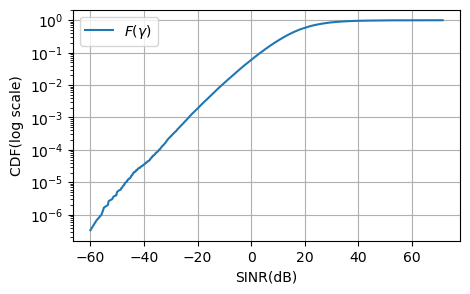

In [13]:
a1, cdf1 = return_cdf(all_SINRsdB.flatten())
plt.figure(figsize= [5,3])
#plt.ylim(np.min(cdf2))
plt.semilogy(a1, cdf1, label = r'$F(\gamma)$')
plt.grid()
plt.xlabel('SINR(dB)')
plt.ylabel('CDF(log scale)')
plt.legend()
print(np.mean(all_SINRsdB.flatten()))

In [14]:
all_SINRsdB.shape

(10000, 10, 5, 6)

### The below model needs to be integrated with DRL framework trained paralelly. 


##### prediction of SINR at t given 10 previous time slots #########
####### 10000 x 5x 5 x 30, 10000 is time slots, first 5 denotes the sub networks, 2nd 5 denotes the devices of a sub network, 
####### 30 denotes the channel resources. 


#### preparing data for a sub-network ########
######## each sub-network will have one LSTM layer getting trained in parallel with the main DRL agent ########
######### i.e., the LSTM layer is trained for a given example with a loss function and predicted SINR is given as the 
######### input to the DRL framework which is subsequently trained. This happens in an online fashion at every time-slot.

In [15]:
## data for a sub-network 
lag = 10
inp_data, out_data = [], []
for i in range(M):
    sinr_sub_nw = all_SINRsdB[:,0,:,:]
    data_per_device = sinr_sub_nw[:,0,:]
    for t in range(0, len(data_per_device)-lag):
        inp_data.append(data_per_device[t:t+lag])
        out_data.append(data_per_device[t+lag])

    
inp_data = np.array(inp_data)
out_data = np.array(out_data)

In [16]:
inp_data.shape

(99900, 10, 6)

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [18]:
samp_no = int(0.95*inp_data.shape[0])
inp_train_data = inp_data[0:samp_no]
out_train_data = out_data[0:samp_no]
inp_test_data = inp_data[samp_no:]
out_test_data = out_data[samp_no:]

# Convert numpy arrays to PyTorch tensors
inp_train_data = torch.tensor(inp_train_data, dtype=torch.float32)
out_train_data = torch.tensor(out_train_data, dtype=torch.float32)
inp_test_data = torch.tensor(inp_test_data, dtype=torch.float32)
out_test_data = torch.tensor(out_test_data, dtype=torch.float32)


inp_test_data 
# Create a dataset and dataloader
train_dataset = TensorDataset(inp_train_data, out_train_data)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


In [19]:
# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
input_dim = N
hidden_dim = 128
output_dim = N
num_layers = 1
num_epochs = 50
learning_rate = 1e-3

# Initialize the model, loss function and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epoch_loss = []
# Training loop
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/50], Step [100/1483], Loss: 180.9315
Epoch [1/50], Step [200/1483], Loss: 48.2344
Epoch [1/50], Step [300/1483], Loss: 11.8874
Epoch [1/50], Step [400/1483], Loss: 5.6700
Epoch [1/50], Step [500/1483], Loss: 3.8696
Epoch [1/50], Step [600/1483], Loss: 2.3383
Epoch [1/50], Step [700/1483], Loss: 2.6236
Epoch [1/50], Step [800/1483], Loss: 1.9297
Epoch [1/50], Step [900/1483], Loss: 1.2183
Epoch [1/50], Step [1000/1483], Loss: 0.9455
Epoch [1/50], Step [1100/1483], Loss: 1.6101
Epoch [1/50], Step [1200/1483], Loss: 1.1432
Epoch [1/50], Step [1300/1483], Loss: 1.6283
Epoch [1/50], Step [1400/1483], Loss: 0.8956
Epoch [2/50], Step [100/1483], Loss: 3.3859
Epoch [2/50], Step [200/1483], Loss: 0.7007
Epoch [2/50], Step [300/1483], Loss: 0.9402
Epoch [2/50], Step [400/1483], Loss: 0.3727
Epoch [2/50], Step [500/1483], Loss: 0.9201
Epoch [2/50], Step [600/1483], Loss: 0.4685
Epoch [2/50], Step [700/1483], Loss: 0.3031
Epoch [2/50], Step [800/1483], Loss: 0.3768
Epoch [2/50], Step [900

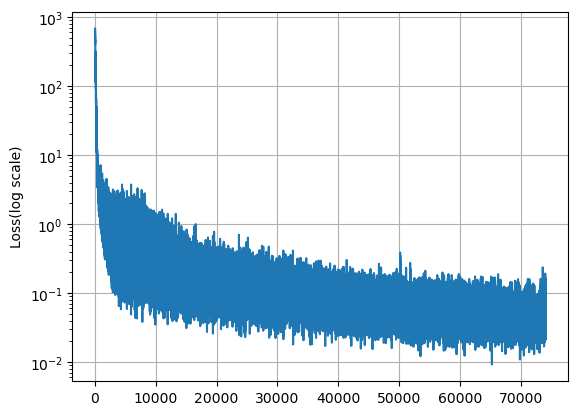

In [20]:
#plt.figure(1, figsize = [20,10])
plt.semilogy(epoch_loss)
plt.ylabel('Loss(log scale)')
plt.grid()

In [21]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_inputs = torch.tensor(inp_test_data, dtype=torch.float32).to(device)
    test_targets = torch.tensor(out_test_data, dtype=torch.float32).to(device)
    test_outputs = model(test_inputs)
    test_loss = criterion(test_outputs, test_targets)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0491


/tmp/ipykernel_1997799/1681708791.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(inp_test_data, dtype=torch.float32).to(device)
/tmp/ipykernel_1997799/1681708791.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_targets = torch.tensor(out_test_data, dtype=torch.float32).to(device)


In [22]:
test_targets.shape

torch.Size([4995, 6])

In [23]:
########## CDF plots ###########
pred = test_outputs.detach().numpy()
tgt = test_targets.detach().numpy()
error = tgt - pred
#pred = pred.flatten()
#tgt = tgt.flatten()
sortd_pred, a_pred = return_cdf(pred[:,0])
sortd_tgt, a_tgt = return_cdf(tgt[:,0])


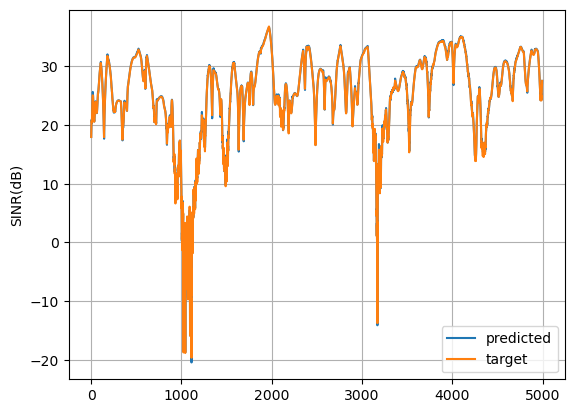

In [24]:
plt.plot(pred[:,3], alpha = 1, label = 'predicted')
plt.plot(tgt[:,3], label = 'target')
plt.legend()
plt.ylabel('SINR(dB)')
plt.grid()
plt.show()

In [26]:
import pickle
'''
LSTM_res = {}
LSTM_res['epoch_loss'] = epoch_loss
LSTM_res['pred'] = pred[:,3]
LSTM_res['tgt'] = tgt[:,3]

with open('LSTM_res.pickle', 'wb') as handle:
    pickle.dump(LSTM_res, handle, protocol=pickle.HIGHEST_PROTOCOL)
''';

In [25]:
#torch.save(model.state_dict(), 'LSTM_state_dict_2agents_V1.pth')
#np.save( 'alltime_fast_fading_gains_2agents.npy',alltime_fast_fading_gains)
#np.save( 'TxRxds_2agents.npy',TxRxds)